## Прогнозирование стоимости автомобиля по характеристикам

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

import pandas_profiling
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

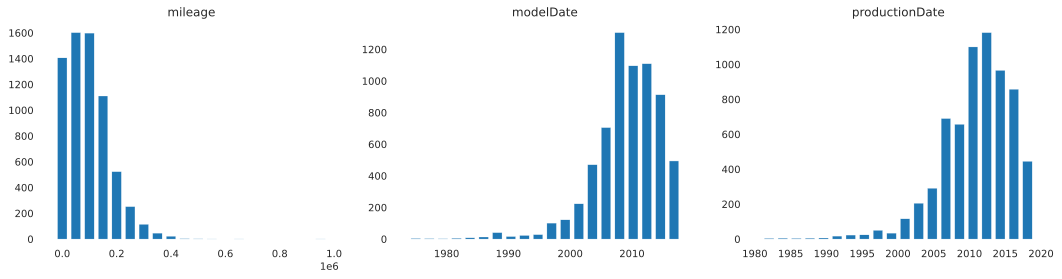

In [13]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

## Разведочный анализ с Pandas profiling

In [14]:
profile = ProfileReport(train)
profile

Анализ показал наличие высокой корреляции между столбцами productionDate и modelDate, numberOfDoors и bodyType. Наличие пропущенных значений в столбце Владение и Владельцы. Наличие других значений в столбцах bodyType, color, description, engineDisplacement, enginePower, model_info, name, vehicleConfiguration, Владение.

## Предобработка

In [15]:
#Заполним столбец Владельцы пунктом 3 и более
train['Владельцы'] = train['Владельцы'].fillna('3')
train.Владельцы = train.Владельцы.apply(lambda x: x[0])
test.Владельцы = test.Владельцы.apply(lambda x: x[0])
train.Владельцы = train.Владельцы.values.astype('int64')
test.Владельцы = test.Владельцы.values.astype('int64')

#Приведем признак enginePower к числову формату
train['enginePower'] = train['enginePower'].apply(lambda x: x.replace(' N12', ''))
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))
train['enginePower'] = train['enginePower'].values.astype('int64')
test['enginePower'] = test['enginePower'].values.astype('int64')

#Приведем признак engineDisplacement к числову формату
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x[:3])
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:3])
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: 2.0 if x == 'und' else x)
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 2.0 if x == 'und' else x)
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float32')
test['engineDisplacement'] = test['engineDisplacement'].values.astype('float32')

#Выделим из признака bodyType 7 (составляют более 2% от всей выборки) основных, остальные заменим общим типом "other"
train['bodyType2'] = train.bodyType
bodyType = train.bodyType2.value_counts()[:7]
test['bodyType2'] = test.bodyType
train['bodyType2'] = train['bodyType2'].apply(lambda x: x if x in bodyType else 'other')
test['bodyType2'] = test['bodyType2'].apply(lambda x: x if x in bodyType else 'other')

#Выделим из признака color 7 (составляют более 2% от всей выборки) основных, остальные заменим общим типом "other"
train['color2'] = train.color
test['color2'] = test.color
color = train.color2.value_counts()[:7]
train['color2'] = train['color2'].apply(lambda x: x if x in color else 'other')
test['color2'] = test['color2'].apply(lambda x: x if x in color else 'other')

train.loc[train['model_info'] == 'None', 'model_info'] = 'OTHER_KLASSE'

# PreProc Tabular Data

In [16]:
#используем
categorical_features = ['bodyType2', 'brand', 'color', 'color2', 'engineDisplacement', 'enginePower', 
                        'fuelType', 'model_info','numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

# бинарные
binary_features = ['ПТС']

In [17]:
columns = ['brand', 'color', 'description', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_info', 'numberOfDoors',
       'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'bodyType2', 
       'color2',  'price','sell_id']

In [18]:
columns1 = ['brand', 'color', 'description', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_info', 'numberOfDoors',
       'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'bodyType2', 
       'color2','sell_id']

In [19]:
df_train = train[columns]
df_test = test[columns1]

In [20]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
print(df_train.shape, df_test.shape, data.shape)

(6682, 20) (1671, 19) (8353, 20)


In [21]:
from sklearn.preprocessing import LabelEncoder

bin_cols = ['ПТС']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

brand      color                                        description  \
0  MERCEDES     чёрный  Всем привет!\n\nПродам эксклюзивный проект 124...   
1       BMW      белый  Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...   
2       BMW  пурпурный  Машина тут продаётся не в первый раз, НО! Толь...   
3       BMW      белый  Автомобиль в отличном состоянии, весь в родной...   
4       BMW     чёрный  Немка! с бесключивым доступом и камерой заднег...   

   engineDisplacement  enginePower fuelType  mileage  modelDate model_info  \
0                 3.0          220   бензин   350000       1984       W124   
1                 3.0          313   дизель    15000       2011        6ER   
2                 2.5          218   бензин   166600       2005        3ER   
3                 2.0          136   бензин   147000       2005        3ER   
4                 2.0          190   дизель    24000       2016        5ER   

   numberOfDoors  productionDate vehicleTransmission  Владельцы  ПТС  Привод  \
0              5            1991      автоматическая          3    1  задний   
1              2            2013      автоматическая          1    1  полный   
2              2            2008      автоматическая          3    1  полный   
3              4            2007      автоматическая          2    1  задний   
4              4            2019      автоматическая          1    1  полный   

         bodyType2  color2     sell_id  sample  price  
0  универсал 5 дв.  чёрный  1099427284       0    NaN  
1             купе   белый  1096405886       0    NaN  
2             купе   other  1100195294       0    NaN  
3            седан   белый  1099827282       0    NaN  
4            седан  чёрный  1100076198       0    NaN

In [22]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis = 1, inplace=True)
    
    data['enginePower'] = np.log(data['enginePower'])
    data['mileage'] = np.log(data['mileage'])
    data['engineDisplacement'] = np.log(data['enginePower'])  
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [23]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

mileage  modelDate  productionDate  ПТС  sample      price  \
7399  0.106999   0.895833        0.868421    1       1  1590000.0   
4273  0.044999   0.875000        0.894737    1       1  3100000.0   
3362  0.054999   0.875000        0.868421    1       1  3750000.0   
2794  0.124999   0.833333        0.763158    1       1  1990000.0   
5378  0.148999   0.875000        0.868421    1       1  1285000.0   
5902  0.069799   0.854167        0.815789    1       1  3399999.0   
1454  0.052765   0.854167        0.868421    1       0        NaN   
2476  0.173499   0.750000        0.684211    0       1   700000.0   
743   0.119999   0.750000        0.736842    1       0        NaN   
1168  0.035999   0.854167        0.842105    1       0        NaN   

      bodyType2_0  bodyType2_1  bodyType2_2  bodyType2_3  ...  \
7399            0            1            0            0  ...   
4273            0            1            0            0  ...   
3362            0            0            0            0  ...   
2794            0            0            0            0  ...   
5378            0            0            0            0  ...   
5902            0            0            0            0  ...   
1454            0            0            0            0  ...   
2476            0            0            0            0  ...   
743             0            0            0            0  ...   
1168            0            1            0            0  ...   

      vehicleTransmission_0  vehicleTransmission_1  vehicleTransmission_2  \
7399                      1                      0                      0   
4273                      1                      0                      0   
3362                      1                      0                      0   
2794                      0                      0                      0   
5378                      1                      0                      0   
5902                      1                      0                      0   
1454                      1                      0                      0   
2476                      1                      0                      0   
743                       1                      0                      0   
1168                      1                      0                      0   

      vehicleTransmission_3  Владельцы_0  Владельцы_1  Владельцы_2  Привод_0  \
7399                      0            1            0            0         0   
4273                      0            1            0            0         0   
3362                      0            0            0            1         0   
2794                      1            0            0            1         0   
5378                      0            0            0            1         0   
5902                      0            1            0            0         0   
1454                      0            0            1            0         0   
2476                      0            0            0            1         1   
743                       0            0            0            1         1   
1168                      0            0            0            1         0   

      Привод_1  Привод_2  
7399         0         1  
4273         0         1  
3362         0         1  
2794         0         1  
5378         0         1  
5902         0         1  
1454         0         1  
2476         0         0  
743          0         0  
1168         0         1  

[10 rows x 382 columns]

In [24]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 382 entries, mileage to Привод_2
dtypes: float64(4), int64(2), uint8(376)
memory usage: 3.4 MB


## Split data

In [25]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 381 entries, mileage to Привод_2
dtypes: float64(4), int64(1), uint8(376)
memory usage: 691.9 KB


# Model 2: CatBoostRegressor

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [28]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9870003	test: 1.0113984	best: 1.0113984 (0)	total: 54.7ms	remaining: 4m 33s
100:	learn: 0.3626735	test: 0.3697966	best: 0.3697966 (100)	total: 398ms	remaining: 19.3s
200:	learn: 0.2917008	test: 0.2974196	best: 0.2974196 (200)	total: 696ms	remaining: 16.6s
300:	learn: 0.2402604	test: 0.2472064	best: 0.2472064 (300)	total: 1s	remaining: 15.7s
400:	learn: 0.2193906	test: 0.2278487	best: 0.2278487 (400)	total: 1.3s	remaining: 14.9s
500:	learn: 0.2067577	test: 0.2149855	best: 0.2149740 (498)	total: 1.61s	remaining: 14.4s
600:	learn: 0.1964604	test: 0.2049256	best: 0.2049256 (600)	total: 1.91s	remaining: 14s
700:	learn: 0.1880083	test: 0.1973571	best: 0.1973571 (700)	total: 2.22s	remaining: 13.6s
800:	learn: 0.1791055	test: 0.1896606	best: 0.1896606 (800)	total: 2.52s	remaining: 13.2s
900:	learn: 0.1715776	test: 0.1822840	best: 0.1822840 (900)	total: 2.83s	remaining: 12.9s
1000:	learn: 0.1658650	test: 0.1771416	best: 0.1771416 (1000)	total: 3.15s	rem

In [29]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 13.32%


Получил МАРЕ 13.65 чуть хуже, чем в бейслайне

### Submission

In [30]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [31]:
X_train.head(5)

mileage  modelDate  productionDate  ПТС  bodyType2_0  bodyType2_1  \
7320  0.149999   0.770833        0.763158    1            0            0   
8037  0.020941   0.937500        0.947368    1            0            1   
4681  0.133896   0.687500        0.631579    1            0            0   
6014  0.329999   0.729167        0.657895    1            0            0   
3649  0.125999   0.833333        0.815789    1            0            0   

      bodyType2_2  bodyType2_3  bodyType2_4  bodyType2_5  ...  \
7320            0            0            0            1  ...   
8037            0            0            0            0  ...   
4681            0            0            0            1  ...   
6014            0            0            0            1  ...   
3649            0            0            0            1  ...   

      vehicleTransmission_0  vehicleTransmission_1  vehicleTransmission_2  \
7320                      1                      0                      0   
8037                      1                      0                      0   
4681                      1                      0                      0   
6014                      1                      0                      0   
3649                      1                      0                      0   

      vehicleTransmission_3  Владельцы_0  Владельцы_1  Владельцы_2  Привод_0  \
7320                      0            1            0            0         1   
8037                      0            1            0            0         0   
4681                      0            0            0            1         0   
6014                      0            0            0            1         1   
3649                      0            1            0            0         0   

      Привод_1  Привод_2  
7320         0         0  
8037         0         1  
4681         0         1  
6014         0         0  
3649         0         1  

[5 rows x 380 columns]

## Simple Dense NN

In [32]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               195072    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 326,657
Trainable params: 326,657
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [35]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [36]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

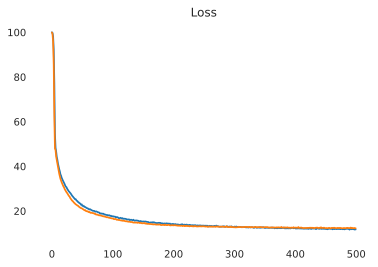

In [37]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [38]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [39]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.28%


In [40]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [41]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [42]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [43]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [44]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s


In [45]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [46]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


In [47]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [48]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [49]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [50]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [51]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [52]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [53]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [54]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 424ms/step - loss: 99.9869 - MAPE: 99.9869 - val_loss: 99.8318 - val_MAPE: 99.8318
Epoch 2/500
12/12 [==============================] - 5s 385ms/step - loss: 98.4192 - MAPE: 98.4192 - val_loss: 92.7328 - val_MAPE: 92.7328
Epoch 3/500
12/12 [==============================] - 4s 356ms/step - loss: 76.3148 - MAPE: 76.3148 - val_loss: 48.5402 - val_MAPE: 48.5402
Epoch 4/500
12/12 [==============================] - 4s 372ms/step - loss: 51.6343 - MAPE: 51.6343 - val_loss: 45.3171 - val_MAPE: 45.3171
Epoch 5/500
12/12 [==============================] - 4s 360ms/step - loss: 45.3320 - MAPE: 45.3320 - val_loss: 41.7185 - val_MAPE: 41.7185
Epoch 6/500
12/12 [==============================] - 5s 391ms/step - loss: 41.2513 - MAPE: 41.2513 - val_loss: 38.0283 - val_MAPE: 38.0283
Epoch 7/500
12/12 [==============================] - 4s 357ms/step - loss: 38.2455 - MAPE: 38.2455 - val_loss: 35.2213 - val_MAPE: 35.2213
Epoch 8/500
12/12 [========

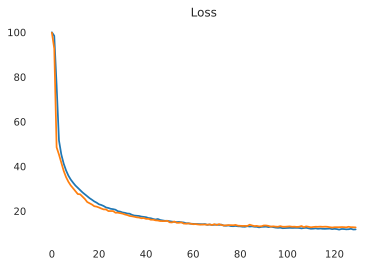

In [55]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [56]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [57]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.71%


In [58]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   float32
 5   enginePower           6682 non-null   int64  
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

### Data

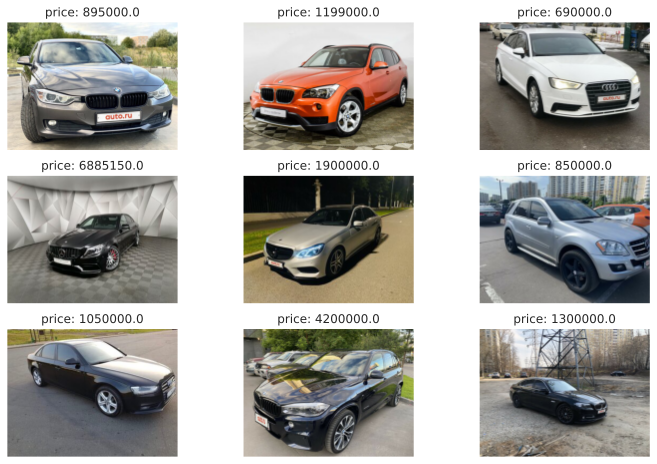

In [60]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [61]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

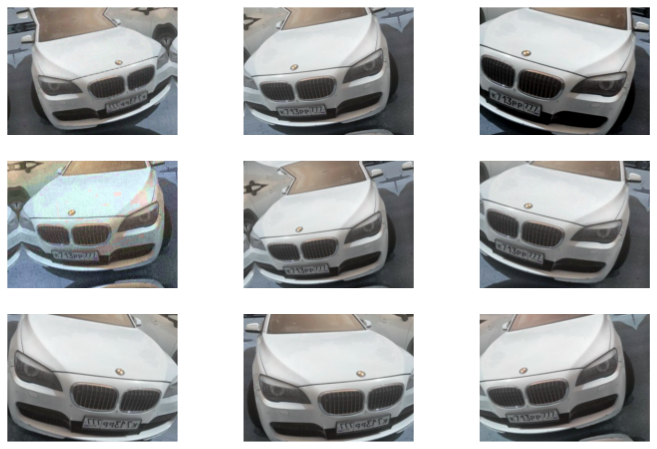

In [62]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [63]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [64]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [65]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [66]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [67]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [68]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [69]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [70]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [71]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [72]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 145s 762ms/step - loss: 52.8408 - MAPE: 52.8408 - val_loss: 32.9951 - val_MAPE: 32.9951
Epoch 2/100
190/190 [==============================] - 142s 747ms/step - loss: 30.9365 - MAPE: 30.9365 - val_loss: 25.9688 - val_MAPE: 25.9688
Epoch 3/100
190/190 [==============================] - 140s 737ms/step - loss: 25.8799 - MAPE: 25.8799 - val_loss: 164.2670 - val_MAPE: 164.2670
Epoch 4/100
190/190 [==============================] - 142s 746ms/step - loss: 22.8971 - MAPE: 22.8971 - val_loss: 21.2234 - val_MAPE: 21.2234
Epoch 5/100
190/190 [==============================] - 142s 746ms/step - loss: 20.9325 - MAPE: 20.9325 - val_loss: 19.4219 - val_MAPE: 19.4219
Epoch 6/100
190/190 [==============================] - 142s 748ms/step - loss: 19.6006 - MAPE: 19.6006 - val_loss: 379.6418 - val_MAPE: 379.6418
Epoch 7/100
190/190 [==============================] - 141s 743ms/step - loss: 18.3186 - MAPE: 18.3186 - val_loss: 17.0754 - val_MAPE: 17.

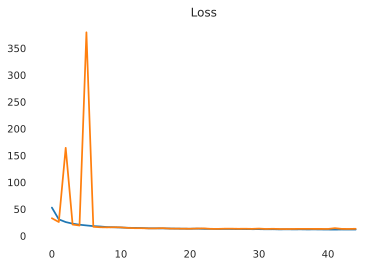

In [73]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [74]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [75]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.35%


In [76]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [77]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.67%


In [78]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [79]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [80]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [81]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [82]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 380)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          195072      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [83]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [84]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 21ms/step - loss: 99.9726 - MAPE: 99.9726 - val_loss: 99.6913 - val_MAPE: 99.6913
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 97.4026 - MAPE: 97.4026 - val_loss: 88.7898 - val_MAPE: 88.7898
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 68.4967 - MAPE: 68.4967 - val_loss: 50.8956 - val_MAPE: 50.8956
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 51.8935 - MAPE: 51.8935 - val_loss: 45.1374 - val_MAPE: 45.1374
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 45.0862 - MAPE: 45.0862 - val_loss: 40.7971 - val_MAPE: 40.7971
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 40.1742 - MAPE: 40.1742 - val_loss: 37.4220 - val_MAPE: 37.4220
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 37.4243 - MAPE: 37.4243 - val_loss: 34.5036 - val_MAPE: 34.5036
Epoch 8/500
12/12 [=====================

In [85]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.76%
